In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit


In [76]:
import pandas as pd
import numpy as np
from sympy import Symbol,expand

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm import tqdm

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
depids_wo293 = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_296b','ml20_313a','ml21_295a','ml21_305b'] #'ml20_293a',

path = 'E:/individus_filtered'

In [4]:
rows=[]
for depid in depids[0:1]:
    _df = pd.read_csv(os.path.join(path,depid,f"{depid}_dive.csv"))
    for _, row in tqdm(_df.iterrows(), desc=depid):
        npz_path = os.path.join(path,depid,"dives",f'acoustic_dive_{int(row["dive"]):05d}.npz')
        npz = np.load(npz_path)
        freq, spectro = npz["freq"], npz["spectro"]
        
        mask = npz["depth"] > 10
        spectro_masked = spectro[mask] 

        target_length = 600
        current_length = spectro_masked.shape[0]

        if current_length < target_length:
            pad_width = ((0, target_length - current_length), (0, 0)) 
            padded_spectro = np.pad(spectro_masked, pad_width, mode='constant')
        else:
            padded_spectro = spectro_masked[:target_length, :]

        flat_spectro = padded_spectro.flatten()
        row_npz = np.insert(flat_spectro, 0, row["precipitation_GPM"])
        rows.append(row_npz)
        
final_array = np.stack(rows)
df = pd.DataFrame(final_array)
df.rename(columns={0: "precipitation_GPM"}, inplace=True)

ml17_280a: 1859it [00:17, 105.87it/s]


In [5]:
df= df.rename(str,axis="columns") 

In [6]:
df_c = df.dropna()

print(df.shape[0]-df_c.shape[0],"lines cleaned removing NaN")

5 lines cleaned removing NaN


In [7]:
y, X  = df_c["precipitation_GPM"], df_c.drop(columns="precipitation_GPM")

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_reduced = X_scaled[:, ::5]
print(X_scaled.shape)
print(X_reduced.shape)

(1854, 307800)
(1854, 61560)


In [10]:
pca = PCA()
pca.fit(X_reduced)

PCA()

Number of components that explain 90.0% variance: 44


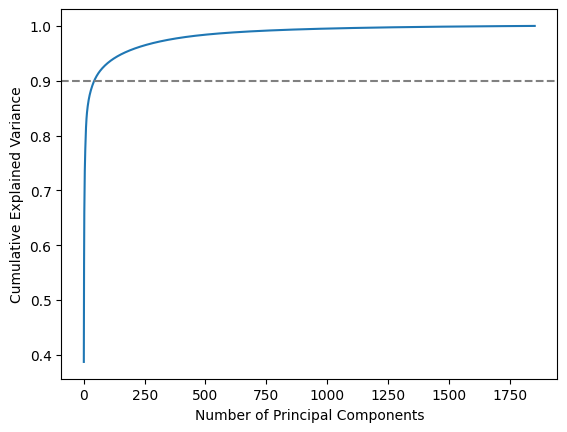

In [11]:
threshold = 0.90 
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components that explain {threshold*100}% variance: {n_components}")

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, color='grey', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [12]:
n_components = 44
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)

X_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(n_components)])

In [49]:
bins = [0, 0.1, 1, 5, np.inf]
labels = [0, 1, 2, 3]  

y_binned = np.digitize(y, bins=bins, right=False)
unique, counts = np.unique(y_binned, return_counts=True)
print(dict(zip(unique, counts)))

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.33, random_state=42, stratify=y_binned
)
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42, stratify=y)

{np.int64(1): np.int64(1562), np.int64(2): np.int64(200), np.int64(3): np.int64(88), np.int64(4): np.int64(4)}


In [ ]:
model = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=1000, criterion="squared_error")
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
R_Utils.print_metrics(y_preds,y_test)

mae : 0.23079867771764315
rmse : 0.5409281758000537
r2 : 0.010942425751978124
var : 0.29257431743730594
std : 0.5409013934510669
cc : 0.17705860905091672


In [70]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
R_Utils.print_metrics(y_preds,y_test)

mae : 0.24824544424184616
rmse : 0.5620944508797886
r2 : -0.0679746934724994
var : 0.3135100611120424
std : 0.5599196916630477
cc : 0.17319808414602378


In [81]:
model = CatBoostRegressor(loss_function='RMSE',allow_writing_files=False)
model.fit(X_train, y_train, verbose=0)
y_preds = model.predict(X_test)
R_Utils.print_metrics(y_preds,y_test)

mae : 0.23259689393314287
rmse : 0.5246949008113667
r2 : 0.06941498848667227
var : 0.27489339402212903
std : 0.5243027694206174
cc : 0.280450644584574


In [78]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
R_Utils.print_metrics(y_preds,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 1242, number of used features: 44
[LightGBM] [Info] Start training from score 0.151160
mae : 0.2549984557692143
rmse : 0.5427832728702866
r2 : 0.004146906188654653
var : 0.2882742671611429
std : 0.5369117871318742
cc : 0.22529097113553445


---

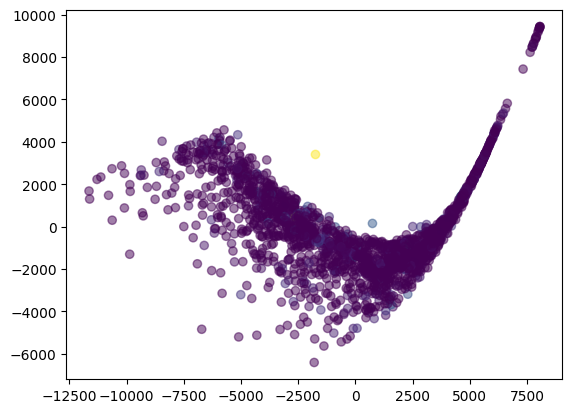

In [8]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
plt.scatter(X_pca["PC1"], X_pca['PC2'], c=y, cmap="viridis", alpha=0.5)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

---

ml17_280a: 1859it [00:09, 198.38it/s]
ml18_296a: 3344it [00:26, 127.09it/s]
ml18_294b: 2387it [00:16, 148.58it/s]
ml19_292a: 2081it [00:14, 146.72it/s]
ml19_292b: 3793it [00:34, 111.25it/s]
ml19_293a: 3798it [00:29, 126.75it/s]
ml19_294a: 3619it [00:27, 131.27it/s]
ml20_293a: 168it [00:01, 85.67it/s] 
ml20_296b: 4925it [00:40, 121.51it/s]
ml20_313a: 2559it [00:16, 154.20it/s]
ml21_295a: 4130it [00:21, 190.09it/s]
ml21_305b: 2231it [00:17, 126.24it/s]


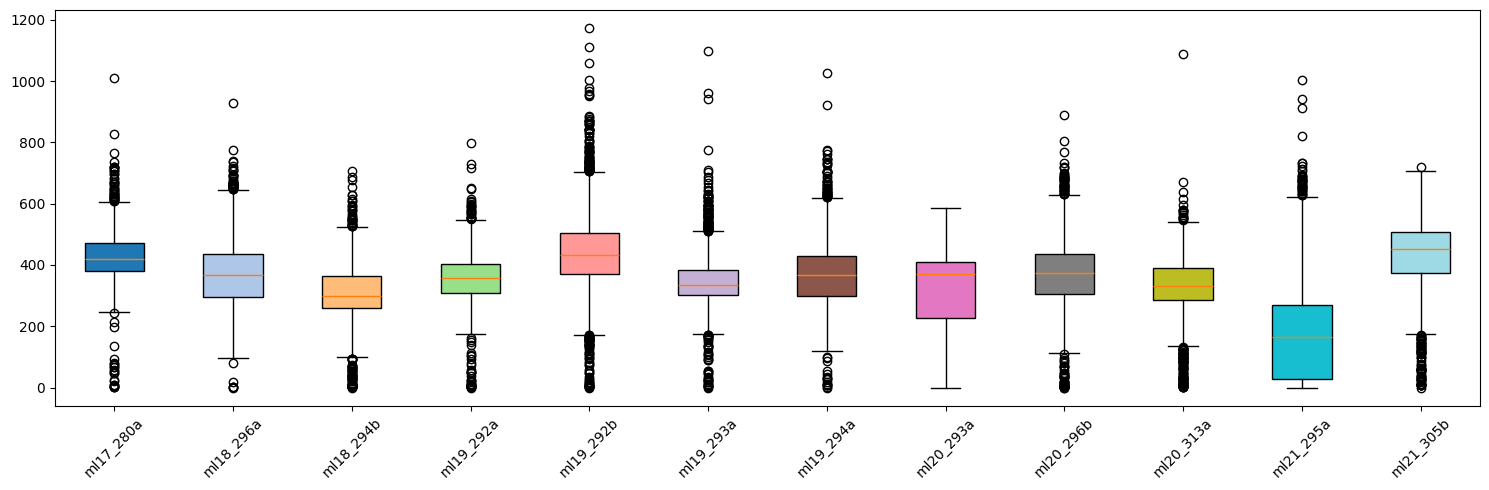

In [4]:
R_Utils.plot_spectro_size_repartition(depids,path)